In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.backend as K
# Use Tensorboard for network visualization & debugging
from tensorflow.keras.callbacks import TensorBoard
import sklearn.metrics
# import regularizer(s)
from tensorflow.keras.regularizers import l1, l2, l1_l2
# import Dropout
from tensorflow.keras.layers import Dropout
# import activation seperately
from tensorflow.keras.layers import Activation


In [20]:
import warnings

#ignore future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [21]:
V52_data = pd.read_csv('V52_data_process.csv')
# make Date the index in datetime format
V52_data.index = pd.to_datetime(V52_data['Date'], format='%Y%m%d%H%M')

data_AS03 = pd.read_csv('WindData_AS03.csv')
# make Date the index in datetime format
data_AS03.index = pd.to_datetime(data_AS03['date_time'], format='%Y-%m-%d %H:%M:%S')


## 1) CREATE A PERSISTANCE MODEL

### Persistance models try to predict the next step in the sequence based on the current step.

If we shift our dataset by one value, we can use it to predict the next value in the sequence. We can do this easily using the shift() function in Pandas. We will add a new column to our dataset called ‘t-1’ that will have the temperature value from the previous hour (t-1) and NA values for the first row as there is no previous hour for the first row.

In [22]:
# Create a function to create the persistance model

def persistance_model(data, time_step):
    """
    This function creates a persistance model for a given time step
    time_step indicates how many time steps in the past we want to use to predict the next time step
    """

    lagged_data = data.shift(time_step)

    # Create a dataframe with the original and lagged data
    df = pd.concat([lagged_data, data], axis=1)
    df.columns = ['t-'+str(time_step), 't']

    # Drop the first time_step rows
    df = df.iloc[time_step:, :]

    # Return the dataframe
    return df

In [23]:
# Try it
time_step = 6
persistance_power = persistance_model(V52_data['ActPow'], time_step)

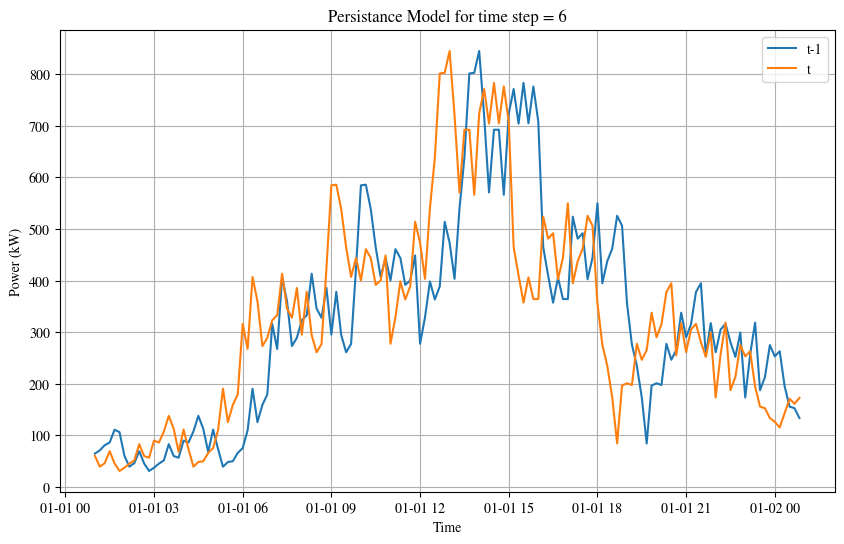

In [24]:
# Plot the persistance model agains the actual data
plt.figure(figsize=(10, 6))
plt.plot(persistance_power['t-'+str(time_step)][0:144], label='t-1')
plt.plot(persistance_power['t'][0:144], label='t')

plt.xlabel('Time')
plt.ylabel('Power (kW)')
plt.grid()

plt.title('Persistance Model for time step = '+str(time_step))
plt.legend()
plt.show()

## COMPUTE THE R^2

In [25]:
# store actual and predicted values using the time_step variable
actual = persistance_power['t']
predicted = persistance_power['t-'+str(time_step)]

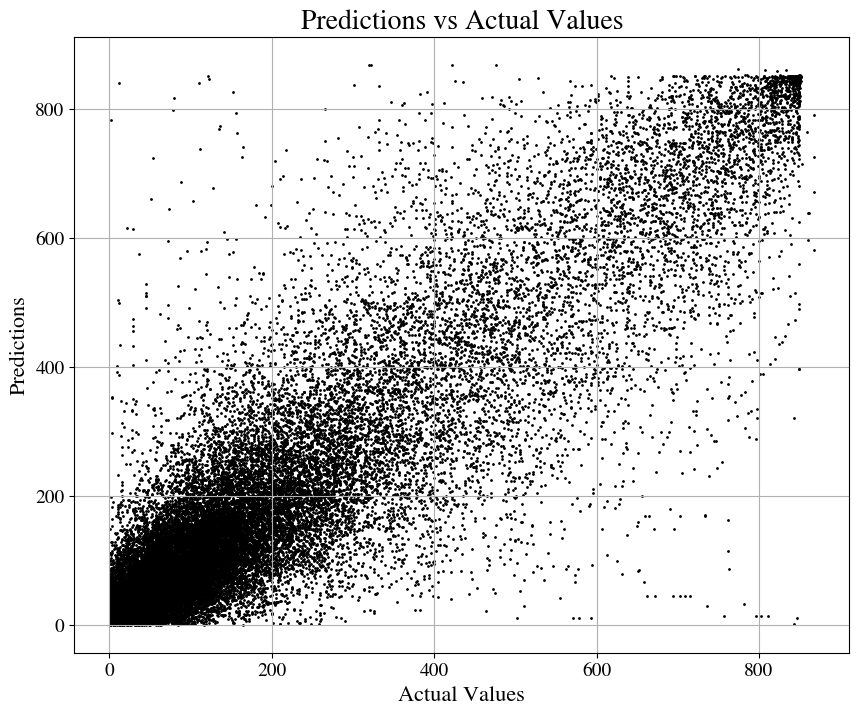

In [26]:
# scatter plot of predictions vs actual
plt.figure(figsize=(10,8))
plt.scatter(actual, predicted, s=1, c='k', marker='o' )
plt.xlabel('Actual Values', fontsize=16)
plt.ylabel('Predictions', fontsize=16)
plt.title('Predictions vs Actual Values', fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)


In [27]:
from sklearn.metrics import r2_score

# Step 1: Check for NaN and Infinity Values
nan_mask = np.isnan(actual) | np.isnan(predicted)
inf_mask = np.isinf(actual) | np.isinf(predicted)

# Step 2: Remove NaN and Infinity Values
actual = actual[~nan_mask & ~inf_mask]
predicted = predicted[~nan_mask & ~inf_mask]

# Step 3: Calculate R2 Score
r2 = r2_score(actual, predicted)

print('R2 Score: ', r2)

R2 Score:  0.8046642567327016


## SECOND PERSISTANCE MODEL
### Predict the future with the average values of the past

In [28]:
### define a function that will prepare the shifting input sequences for the network
def forecast_sequences_input(input_data, n_lag):
    """
    A function that will split the input time series to sequences for nowcast/forecast problems
    Arguments:
        input_data: Time series of input observations as a list, NumPy array or pandas series
        n_lag: number of previous time steps to use for training, a.k.a. time-lag        
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = input_data.shape[1] 
    df = pd.DataFrame(input_data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_lag, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    return agg


### define a function that will prepare the shifting output sequences of the network
def forecast_sequences_output(output_data,n_out):
    """
    A function that will split the output time series to sequences for nowcast/forecast problems
    Arguments:
        output_data: Time series of input observations as a list, NumPy array or pandas series
        n_out: forecast horizon (for multi-output forecast)
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = output_data.shape[1] 
    df = pd.DataFrame(output_data)
    cols, names = list(), list()
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together (aggregate)
    agg = pd.concat(cols, axis=1)
    agg.columns = names    
    return agg


In [29]:
n_past = 6
n_future = 1

# Obtain past and future sequences for the power output
past_power = forecast_sequences_input(V52_data[['ActPow']], n_past)
future_power = forecast_sequences_output(V52_data[['ActPow']], n_future)

# Take out the n_past rows from both dataframes
past_power = past_power.iloc[n_past:, :]
future_power = future_power.iloc[n_past:, :]

# Make the row-mean for the past_power dataframe avoiding NaN values
past_power_mean = past_power.mean(axis=1, skipna=True)

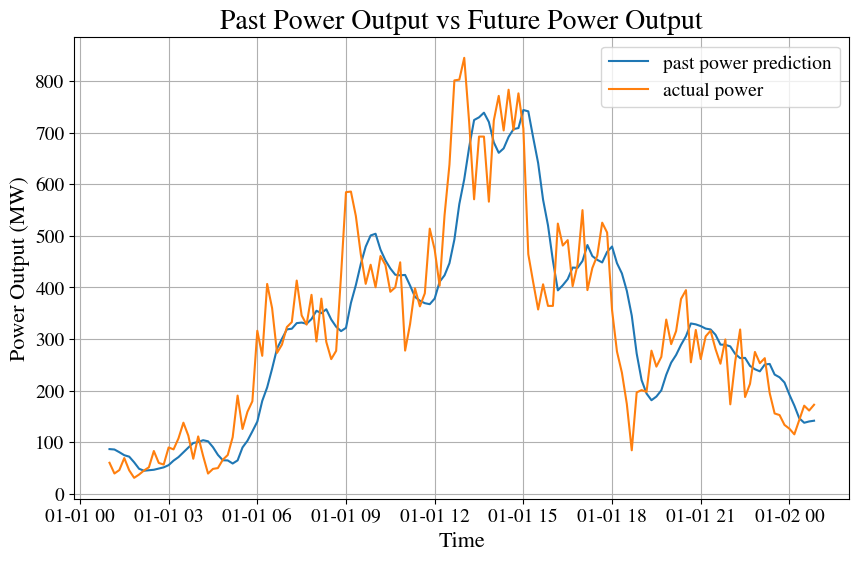

In [30]:
# plot the past_power_mean vs the future_power
plt.figure(figsize=(10, 6))
plt.plot(past_power_mean[0:144], label='past power prediction')
plt.plot(future_power['var1(t)'][0:144], label='actual power')
plt.legend(fontsize=14)
plt.xlabel('Time', fontsize=16)
plt.ylabel('Power Output (MW)', fontsize=16)
plt.title('Past Power Output vs Future Power Output', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True)

In [31]:
actual = future_power['var1(t)']
predicted = past_power_mean


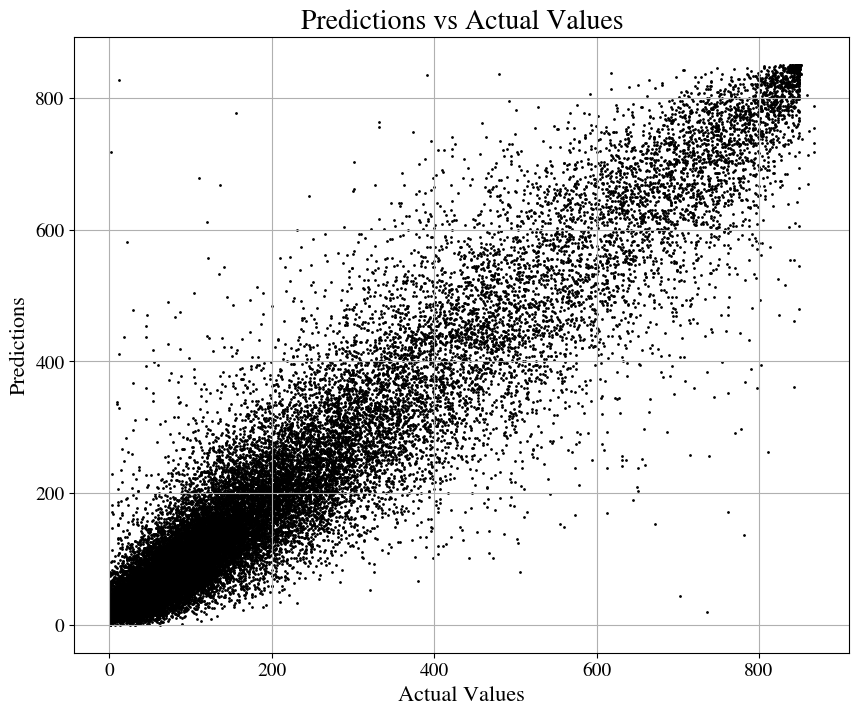

In [32]:
# scatter plot of predictions vs actual
plt.figure(figsize=(10,8))
plt.scatter(actual, predicted, s=1, c='k', marker='o' )
plt.xlabel('Actual Values', fontsize=16)
plt.ylabel('Predictions', fontsize=16)
plt.title('Predictions vs Actual Values', fontsize=20)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)


In [33]:

# Step 1: Check for NaN and Infinity Values
nan_mask = np.isnan(actual) | np.isnan(predicted)
inf_mask = np.isinf(actual) | np.isinf(predicted)

# Step 2: Remove NaN and Infinity Values
actual = actual[~nan_mask & ~inf_mask]
predicted = predicted[~nan_mask & ~inf_mask]

# Step 3: Calculate R2 Score
r2 = r2_score(actual, predicted)

print('R2 Score: ', r2)

R2 Score:  0.9106440907824247
